In [1]:
import sys, os
sys.path.append('../src')
from NeutrinoFogFuncs import *
from NeutrinoFogPlotFuncs import *

In [2]:
import multiprocessing
from NeutrinoFuncs import BinnedNeutrinoRates, BinnedNeutrinoRates2
from WIMPFuncs import BinnedWIMPRate,MeanInverseSpeed_SHM,C_SI, BinnedWIMPRate2
from LabFuncs import FormFactorHelm
from Params import *
#==============================================================================#
ne = 50 # number of energy bins (anything >50 is accurate enough)
nm = 200 # number of mass points
m_vals = np.logspace(log10(0.1),log10(1.0e4),nm) # mass points
Flux_norm = NuFlux # See Params.py
Flux_err = NuUnc # See Params.py
E_th = 1.0e-4 # Threshold
E_max = 200.0 # Max recoil energy

In [3]:
NucList = [Xe131, Ge74, Ar40, He4]

R_sigList = [BinnedWIMPRate(E_th,E_max,ne,m_vals,Nuc,C_SI,FormFactorHelm,MeanInverseSpeed_SHM) for Nuc in NucList]
R_nuList = [BinnedNeutrinoRates(E_th,E_max,ne,Nuc,Flux_norm) for Nuc in NucList]

In [4]:
NucNaI = [Na23,I127]
fNaIList = [22/(22+127), 127/(22+127)]
R_sigNaI = np.sum([fNaIList[i]*BinnedWIMPRate(E_th,E_max,ne,m_vals,\
                    NucNaI[i],C_SI,FormFactorHelm,MeanInverseSpeed_SHM) for i in range(len(fNaIList))], axis=0)
R_nuNaI = np.sum([fNaIList[i]*BinnedNeutrinoRates(E_th,E_max,ne,NucNaI[i],Flux_norm) for i in range(len(fNaIList))], axis=0)

NucCaWO4 = [Ca40,W184,O16]
fCaWO4List = [40/(40+184+4*16), 184/(40+184+4*16), 4*16/(40+184+4*16)]
R_sigCaWO4 = np.sum([fCaWO4List[i]*BinnedWIMPRate(E_th,E_max,ne,m_vals,\
                    NucCaWO4[i],C_SI,FormFactorHelm,MeanInverseSpeed_SHM) for i in range(len(fCaWO4List))], axis=0)
R_nuCaWO4 = np.sum([fCaWO4List[i]*BinnedNeutrinoRates(E_th,E_max,ne,NucCaWO4[i],Flux_norm) for i in range(len(fCaWO4List))], axis=0)

In [5]:
R_sigList.extend([R_sigNaI, R_sigCaWO4])
R_nuList.extend([R_nuNaI, R_nuCaWO4])

In [6]:
phi = 9.
fogDatGen = Fog(phiGen2)
#%time res0 = list(map(lambda x: fogDatGen.sigmaExpoListGen(np.logspace(-3.,9.,130), x, R_nuList[0], NuUnc, phi), R_sigList[0]))

In [7]:
def myMul(R_nu, R_sig):
    pool = multiprocessing.Pool(4)
    multiple_results = [pool.apply_async(\
            fogDatGen.sigmaExpoListGen, (np.logspace(-3.,9.,130), x, R_nu, NuUnc, phi))\
                                         for x in R_sig]
    pool.close()
    pool.join()
    res1= [res.get() for res in multiple_results]
    return res1

In [8]:
%time resList = [myMul(R_nuList[i], R_sigList[i]) for i in range(len(R_sigList))]

CPU times: user 3.23 s, sys: 537 ms, total: 3.77 s
Wall time: 27.4 s


In [9]:
def vFogPlot3(resList, m_vals, color, targetList):
    #
    n = 5
    colors = np.zeros([n,4])
    colors[0] = mpl.colors.to_rgba(color)
    colors[:] = mpl.colors.to_rgba(color)
    colors[:,3] = [0., 0.2, 0.4, 0.6, 0.8]
    cmap = mpl.colors.ListedColormap(colors, name='test')
    pek = line_background(10,'k')
    xlab=r"DM mass [GeV]"
    ylab=r"SI DM-nucleon cross section [cm$^2$]"
    lfs = 35
    
    plt.rcParams['axes.linewidth'] = 2.5
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif',size=25)
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{mathpazo}'
    
    fig, ax = plt.subplots(2,3, figsize=(40,20))
    for i in range(6):
        axx, axy = int(i/3), i%3
        ax[axx,axy]=MakeLimitPlot_SI2023X(ax[axx,axy],xmin=1.0e-1,xmax=1.0e4,ymin=1e-50,ymax=1e-41,\
                     facecolor='darkgray',edgecolor='darkgray',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25)
        m,sig,DY = plotDatGen2(m_vals, resList[i])
        cnt = ax[axx,axy].contourf(m,sig,DY,np.array([1.5, 2., 2.5, 3., 3.5]),\
                       cmap=cmap, vmin=1. , vmax=3.5, zorder=-1)
        for c in cnt.collections:
            c.set_edgecolor("face")
        NUFLOOR = np.array([m_vals, np.transpose(np.array(list(map(findPoint, resList[i]))))[1]])
        [edgeX, edgeY] = NUFLOOR
        ax[axx,axy].plot(edgeX,edgeY,'-',color=color,lw=3,path_effects=pek,zorder=-0.5)
        #ax[axx,axy].text(0.15*(1-0.01),0.16*(1+0.01),r'\bf {0} neutrino fog'.format(targetList[i]),color='k',fontsize=30,alpha=0.2)
        ax[axx,axy].text(0.12,3e-50,r'{0} neutrino fog'.format(targetList[i]),color='black',fontsize=30)
        if [axx,axy]==[0,0] or [axx,axy]==[1,0]:
            ax[axx,axy].set_ylabel(ylab,fontsize=lfs)
        if axx==1:  
            ax[axx,axy].set_xlabel(xlab,fontsize=lfs)

    cmap2 = mpl.colors.ListedColormap(colors[1:-1], name='test')
    cmap2.set_under(color=color, alpha=0.)
    cmap2.set_over(color=color, alpha=1.)
    im = plt.pcolormesh(-m,sig,DY,vmax=3.,vmin=1.5,cmap=cmap2,rasterized=True,shading='auto')
    #fig.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.915, 0.14, 0.011, 0.7])
    cbar=fig.colorbar(im, cax=cbar_ax,orientation='vertical',extend='both',extendfrac=0.03, ticks=[1.5,2,2.5,3.])
    cbar_ax.yaxis.set_ticks_position('left')
    cbar.ax.tick_params(labelsize=25)
    cbar.ax.text(3.2,1.7,r'Gradient of discovery limit, $n = -({\rm d}\ln\sigma_{\rm DL}/{\rm d}\ln N)^{-1}$',\
                   rotation=270,fontsize=30)
    return fig

def MakeLimitPlot_SI2023X(ax, xmin=0.1,xmax=1.0e4,ymax=1.0e-36,ymin=1.0e-51,\
                     facecolor=[0.0, 0.62, 0.38],edgecolor='darkgreen',edgecolor_collected='darkgray',\
                     alph=0.5,lfs=35,tfs=25):
    pek = line_background(5,'k')

#     AllLimits = loadtxt("../data/WIMPLimits/SI/AllLimits-2023.txt")
#     ax.fill_between(AllLimits[:,0], AllLimits[:,1],edgecolor=None,y2=ymax,facecolor=facecolor,alpha=alph,zorder=0)
#     ax.plot(AllLimits[:,0], AllLimits[:,1],color=edgecolor_collected,linewidth=3,alpha=alph,zorder=0.01)
#     for lim in ['CDMSLite','DarkSide','PandaX','XENON1T','LUX','DEAP-3600','EDELWEISS','PICO60','XENONnT','PandaX4T']:
#         dat = loadtxt("../data/WIMPLimits/SI/"+lim+".txt")
#         ax.plot(dat[:,0], dat[:,1],color=edgecolor,linewidth=3,alpha=alph,zorder=0)
    
    ax.text(21.,3.0e-42,r"{\bf CDMSlite}",color="blue",fontsize=22,rotation=0)
    ax.text(2.65,3e-42,r"{\bf DarkSide}",color="green",fontsize=22,rotation=0,ha='right')
    ax.text(650.0,1.6e-45,r"{\bf PandaX-II}",color="navy",fontsize=22,rotation=21)
    ax.text(2.0,1e-44,r"{\bf XENON1T}",color="darkgreen",fontsize=22,rotation=-70)
    ax.text(6.5,2.0e-44,r"{\bf EDELWEISS}",color=[0.67, 0.31, 0.32],fontsize=18,rotation=-25)
    ax.text(2000.0,5.4e-43,r"{\bf PICO60}",color=[0.5, 0.0, 0.13],fontsize=22,rotation=22)
    ax.text(1.5e3,3.5e-44,r'{\bf DEAP-3600}',color='#4ff09d',fontsize=22,rotation=23)
    ax.text(4000.0,8.7e-45,r"{\bf LUX}",color="crimson",fontsize=21,rotation=19)
    ax.text(1800,4e-46,r"{\bf PandaX4T}",color="orange",fontsize=22,rotation=26)
    ax.text(250.0,6e-47,r"{\bf XENONnT}",color="c",fontsize=22,rotation=26)
        
    AllLimits = loadtxt("../data/WIMPLimits/SI/AllLimits-2023.txt")
    ax.fill_between(AllLimits[:,0], AllLimits[:,1],edgecolor=None,y2=ymax,facecolor=facecolor,alpha=alph,zorder=0)
    # Expt limits
    CDMSLite = loadtxt("../data/WIMPLimits/SI/CDMSLite.txt")
    ax.plot(CDMSLite[:,0], CDMSLite[:,1],color="blue",linewidth=3)

    DarkSide = loadtxt("../data/WIMPLimits/SI/DarkSide.txt")
    ax.plot(DarkSide[:,0], DarkSide[:,1],color="green",linewidth=3)

    PandaX = loadtxt("../data/WIMPLimits/SI/PandaX.txt")
    ax.plot(PandaX[:,0], PandaX[:,1],color="navy",linewidth=3)

    XENON1T = loadtxt("../data/WIMPLimits/SI/XENON1T.txt")
    ax.plot(XENON1T[:,0], XENON1T[:,1],color='darkgreen',linewidth=3)

    LUX = loadtxt('../data/WIMPLimits/SI/LUX.txt')
    ax.plot(LUX[:,0], LUX[:,1],color='crimson',linewidth=3)


    EDELWEISS = loadtxt("../data/WIMPLimits/SI/EDELWEISS.txt")
    ax.plot(EDELWEISS[:,0], EDELWEISS[:,1],color=[0.67, 0.31, 0.32],linewidth=3)

    PICO60 = loadtxt("../data/WIMPLimits/SI/PICO60.txt")
    ax.plot(PICO60[:,0], PICO60[:,1],color=[0.5, 0.0, 0.13],linewidth=3)

    dat = loadtxt('../data/WIMPLimits/SI/DEAP-3600.txt')
    ax.plot(dat[:,0], dat[:,1],color='#4ff09d',linewidth=3)
    
    XENONnT = loadtxt("../data/WIMPLimits/SI/XENONnT.txt")
    ax.plot(XENONnT[:,0], XENONnT[:,1],color='c',linewidth=3)
    
    PandaX4T = loadtxt("../data/WIMPLimits/SI/PandaX4T.txt")
    ax.plot(PandaX4T[:,0], PandaX4T[:,1],color='orange',linewidth=3)

    # Labels
    
    ax.tick_params(which='major',direction='in',width=2,length=13,right=True,top=True,pad=7)
    ax.tick_params(which='minor',direction='in',width=1,length=10,right=True,top=True)
    ax.tick_params(labelsize=20)

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_yticks(10.0**arange(-51,-30,1))
    ax.tick_params(which='major',pad=10)
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=ymin, top=ymax)
    return ax

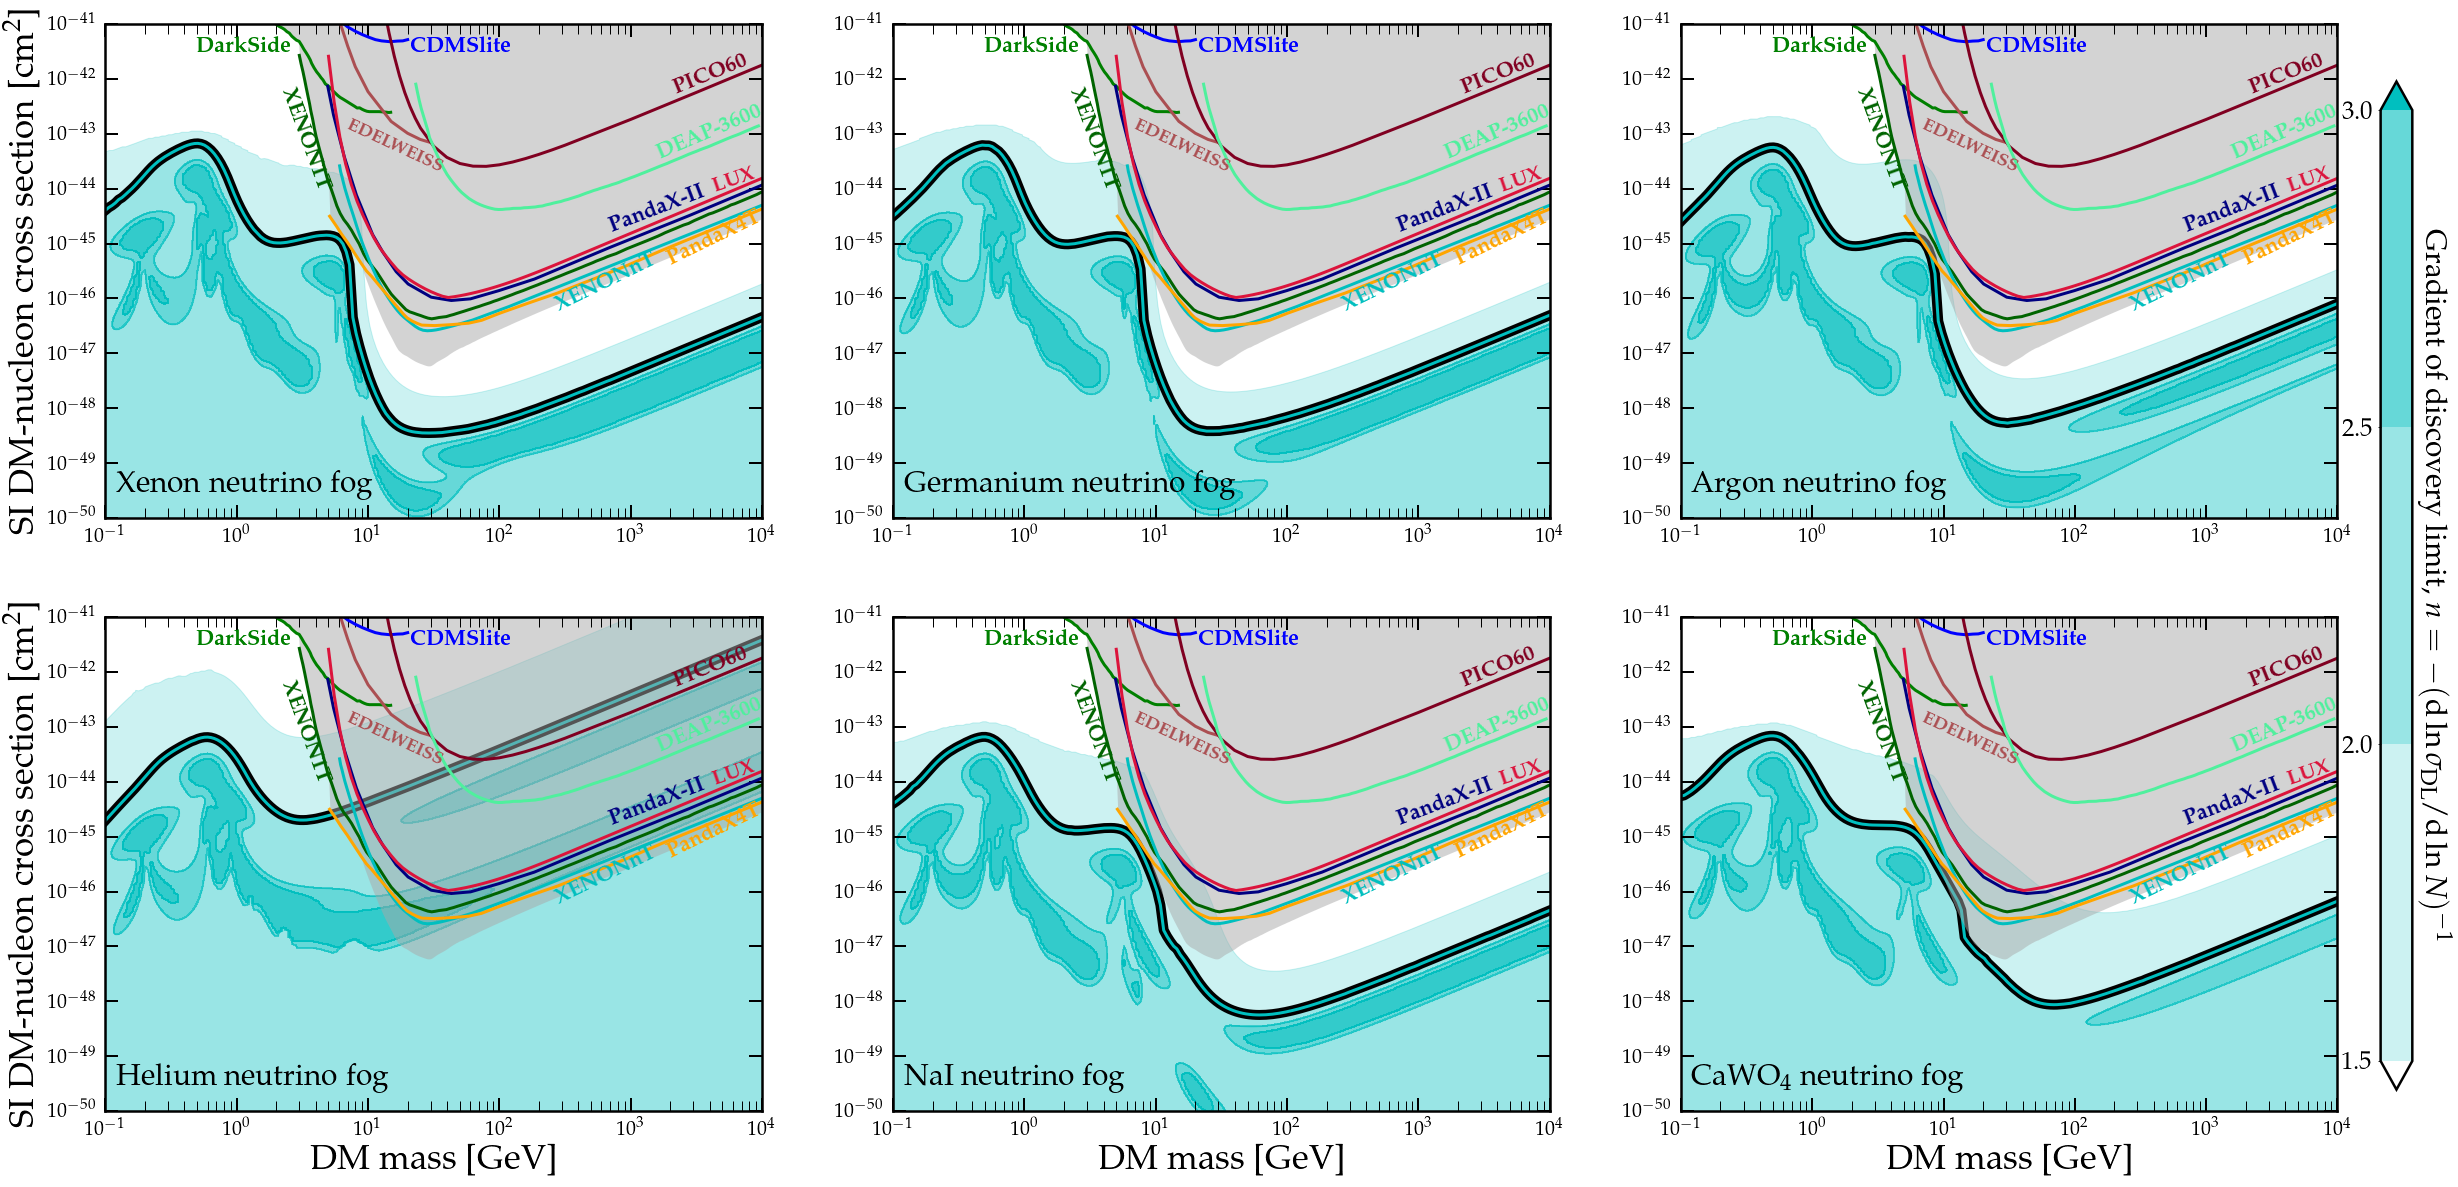

In [10]:
targetList = ['Xenon','Germanium','Argon','Helium','NaI','CaWO$_4$']
method2P0 = vFogPlot3(resList, m_vals, 'c', targetList)

In [11]:
myPathFig = os.path.join(os.path.abspath(os.path.pardir),'plots')
method2P0.savefig(os.path.join(myPathFig,'DifferentTargets.pdf'),bbox_inches='tight')
method2P0.savefig(os.path.join(myPathFig,'png','DifferentTargets.png'),bbox_inches='tight')

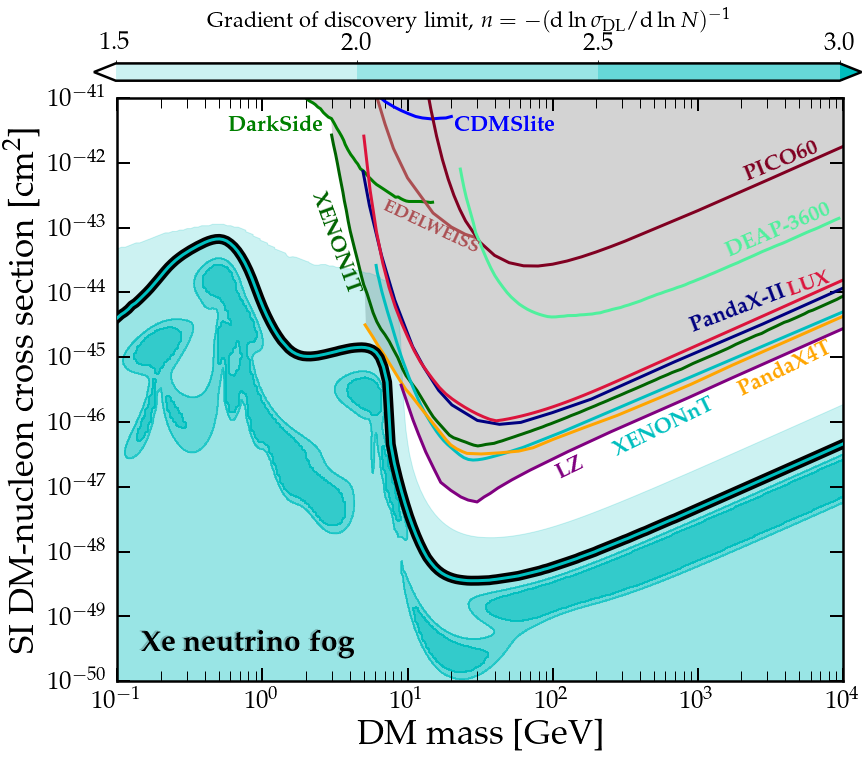

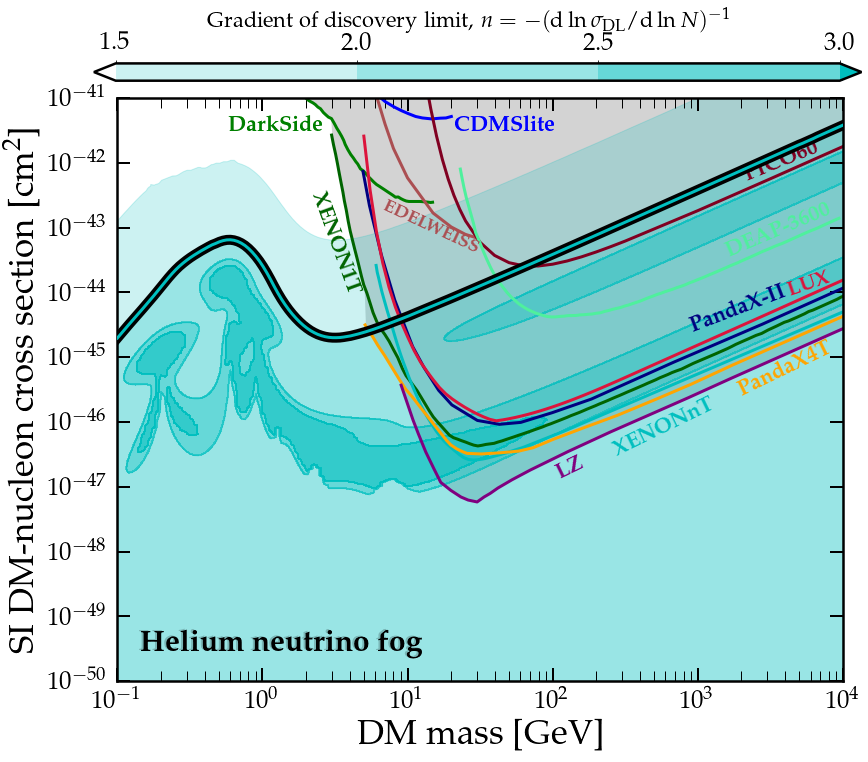

In [12]:
method2P0 = vFogPlot2(resList[0], m_vals, 'c', 'Xe')
method2P0 = vFogPlot2(resList[3], m_vals, 'c', 'Helium')